In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import models, fitting

In [2]:
def BinCenters(bin_edges):
    return (bin_edges[1:]+bin_edges[0:-1])/2.

In [3]:
# We now need to pick a brightness and a level for the random error per pixel
brightness = 10.
sigma_noise = 0.5 

In [4]:
# Let's make an image to hold just one source, with x and y coordinates
Npix = 21
sigma_source = 3.
center = int(Npix/2)
x_coord, y_coord = np.meshgrid(np.arange(Npix), np.arange(Npix))

Notice that `stats.uniform?` will tell us how to use the keywords to get uniform random variables over an interval, and they want is specified as `loc` = left end point, `scale` = number to add to the left endpoint

In [5]:
# Let's constrain the (x,y) position to be toward the center
x0 = stats.uniform.rvs(center-4, 8)
y0 = stats.uniform.rvs(center-4, 8)
#print(x0, y0)

# Make the image
gaussian = Gaussian2D()
signal = gaussian.evaluate(x_coord, y_coord, amplitude=brightness, x_mean=x0, y_mean=y0, 
                           x_stddev=sigma_source, y_stddev=sigma_source, theta=0)
# Make the noise
noise = stats.norm.rvs(loc=0, scale=sigma_noise, size = [Npix, Npix])

# And the sum (the data)
data = signal + noise

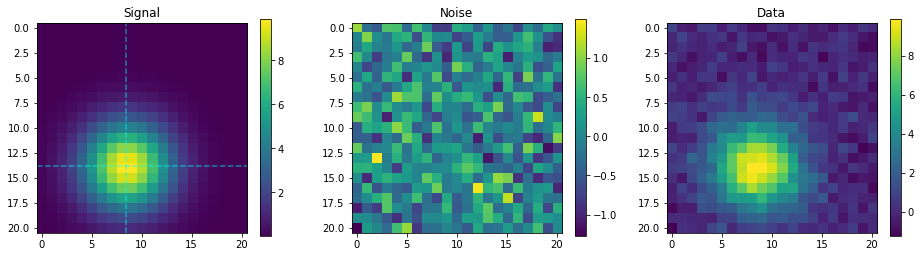

In [6]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(signal)
plt.title('Signal')
plt.axvline(x0,color='cyan',linestyle='--',alpha=0.5)
plt.axhline(y0,color='cyan',linestyle='--',alpha=0.5)
plt.colorbar(shrink=0.8)
plt.subplot(132)
plt.title('Noise')
plt.imshow(noise)
plt.colorbar(shrink=0.8)
plt.subplot(133)
plt.title('Data')
plt.imshow(data)
plt.colorbar(shrink=0.8)
plt.show()

In [7]:
# initialize a fitter
source_fitter = fitting.LevMarLSQFitter()
# initialize a model.  Put initial guess here, which we will assume is at the center of the image.
source_model = models.Gaussian2D(amplitude=data.max(), x_mean=center, y_mean=center, 
                                 x_stddev=sigma_source, y_stddev=sigma_source, theta=0)
# Notice the way that the weights are passed, as 1/standard deviation
fitted_source = source_fitter(source_model, x_coord, y_coord, data, weights=np.ones_like(data)/sigma_noise)
print(fitted_source)
# We want the `cov_x` as the model covariance
print(source_fitter.fit_info['cov_x'])
# This value will be 1 if the fit was determined to be good
print(info.fit_info['ierr'])

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean      ...      y_stddev            theta       
    ------------------ ----------------- ... ------------------ ------------------
    10.135873831058827 8.465429316787192 ... 2.9176574122881647 0.5551161848473934
[[ 1.78063946e-02 -4.86156341e-07 -4.44086127e-05 -2.72881288e-03
  -2.61287526e-03 -2.57390269e-04]
 [-4.86156341e-07  1.59299474e-03  8.07535996e-05  2.17560873e-06
  -1.61172018e-06  1.39148609e-05]
 [-4.44086127e-05  8.07535996e-05  1.52586009e-03  9.82409865e-06
   2.17515816e-05  8.47957336e-05]
 [-2.72881288e-03  2.17560873e-06  9.82409865e-06  1.65714450e-03
   1.08345411e-05  6.74156519e-05]
 [-2.61287526e-03 -1.61172018e-06  2.17515816e-05  1.08345411e-05
   1.50267833e-03  1.17034890e-04]
 [-2.57390269e-04  1.39148609e-05  8.47957336e-05  6.74156519e-05
   1.17034890e-04  2.64414404e-02]]


NameError: name 'info' is not defined

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title('Fitted')
plt.imshow(fitted_source(x_coord, y_coord))
plt.axvline(x0,color='cyan',linestyle='--',alpha=0.5)
plt.axhline(y0,color='cyan',linestyle='--',alpha=0.5)
plt.colorbar(shrink=0.8)
plt.subplot(132)
plt.title('Signal - Fitted')
plt.imshow(signal - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.subplot(133)
plt.title('Data - Fitted')
plt.imshow(data - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.show()

Notice that astropy also fit for the x and y width and the rotation angle theta.  Let's now assume that we actually know these exactly and *don't* want to fit for them.  We need to provide a constraint on these parameters, that they are *fixed*.  `astropy.modelling` provides a way to do this: https://docs.astropy.org/en/stable/modeling/parameters.html#parameter-constraints

In [ ]:
source_model = models.Gaussian2D(amplitude=data.max(), x_mean=center, y_mean=center, 
                                 x_stddev=sigma_source, y_stddev=sigma_source, theta=0)

source_model.x_stddev.fixed = True
source_model.y_stddev.fixed = True
source_model.theta.fixed = True

# Notice the way that the weights are passed, as 1/standard deviation
fitted_source = source_fitter(source_model, x_coord, y_coord, data, weights=np.ones_like(data)/sigma_noise)
print(fitted_source)
# We want the `cov_x` as the model covariance
print(source_fitter.fit_info['cov_x'])
# This value will be 1 if the fit was determined to be good
print(info.fit_info['ierr'])

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title('Fitted')
plt.imshow(fitted_source(x_coord, y_coord))
plt.axvline(x0,color='cyan',linestyle='--',alpha=0.5)
plt.axhline(y0,color='cyan',linestyle='--',alpha=0.5)
plt.colorbar(shrink=0.8)
plt.subplot(132)
plt.title('Signal - Fitted')
plt.imshow(signal - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.subplot(133)
plt.title('Data - Fitted')
plt.imshow(data - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.show()

In [ ]:
source_model.param_names

In [ ]:
source_fitter.fit_info.keys()

In [ ]:
def Cov2Corr(cov):
    norm = np.sqrt(np.diag(cov))
    norm_outer = np.outer(norm, norm)
    corr = cov / norm_outer
    return corr

In [ ]:
Cov2Corr(source_fitter.fit_info['cov_x'])